
# 2.2-kW induction motor, LC filter

This example simulates open-loop V/Hz control of a 2.2-kW induction machine
drive equipped with an LC filter.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from motulator.drive import model
import motulator.drive.control.im as control
from motulator.drive.utils import (
    BaseValues, InductionMachinePars, InductionMachineInvGammaPars,
    NominalValues, plot)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=400, I=5, f=50, P=2.2e3, tau=14.6)
base = BaseValues.from_nominal(nom, n_p=2)

Create the system model. The filter parameters correspond to [#Sal2006]_.



In [4]:
mdl_ig_par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
mdl_par = InductionMachinePars.from_inv_gamma_model_pars(mdl_ig_par)
machine = model.InductionMachine(mdl_par)
# Quadratic load torque profile (corresponding to pumps and fans)
k = 1.1*nom.tau/(base.w/base.n_p)**2
mechanics = model.StiffMechanicalSystem(J=.015, B_L=lambda w_M: k*np.abs(w_M))
converter = model.VoltageSourceConverter(u_dc=540)
lc_filter = model.LCFilter(L_f=8e-3, C_f=9.9e-6, R_f=.1)
mdl = model.DriveWithLCFilter(converter, machine, mechanics, lc_filter)
mdl.pwm = model.CarrierComparison()  # Enable the PWM model

Control system (parametrized as open-loop V/Hz control).



In [5]:
# Inverse-Γ model parameter estimates
par = InductionMachineInvGammaPars(R_s=0*3.7, R_R=0*2.1, L_sgm=.021, L_M=.224)
ctrl = control.VHzControl(
    control.VHzControlCfg(par, nom_psi_s=base.psi, k_u=0, k_w=0))

Set the speed reference. The external load torque is zero (by default).



In [6]:
ctrl.ref.w_m = lambda t: (t > .2)*base.w

Create the simulation object and simulate it.



In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=1.5)

Plot results in per-unit values.



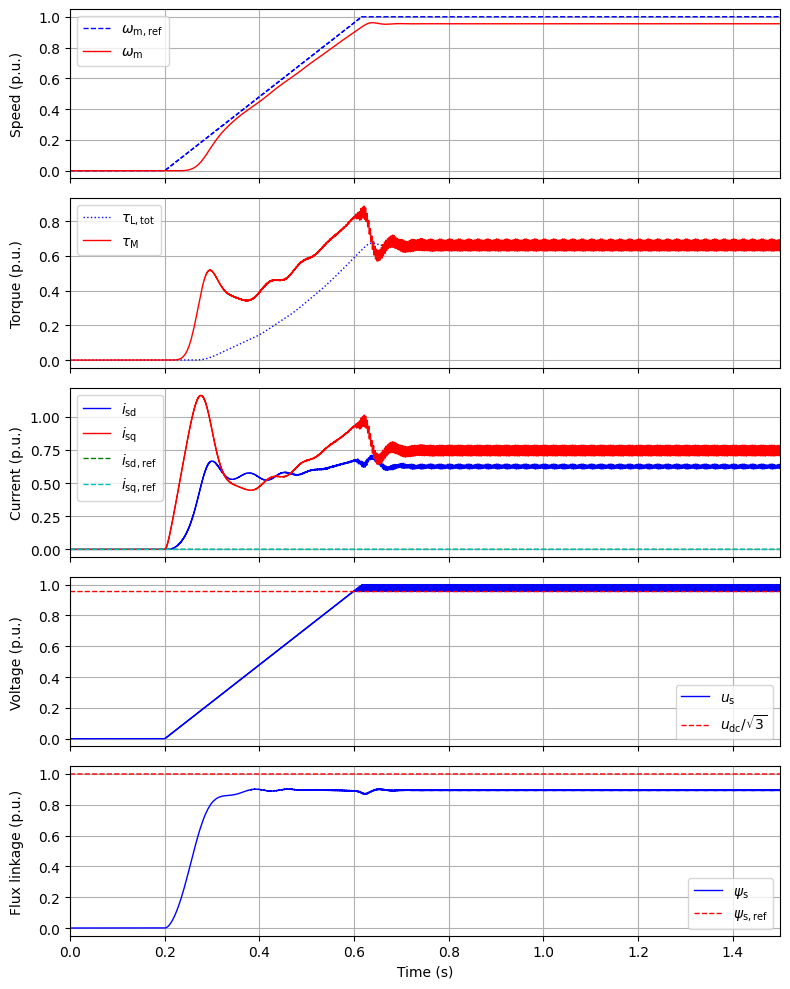

In [8]:
# sphinx_gallery_thumbnail_number = 2
plot(sim, base)

Plot additional waveforms.



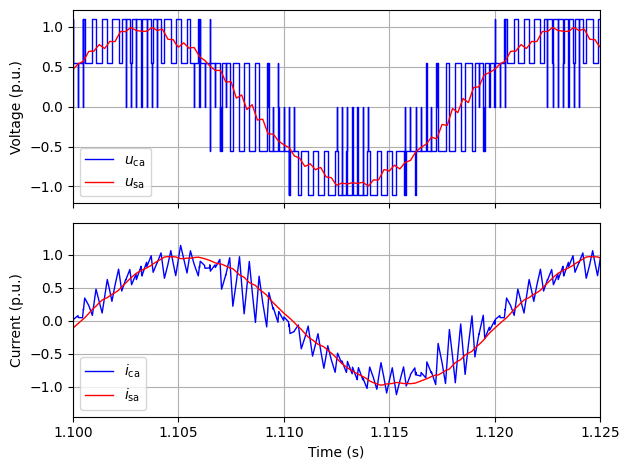

In [9]:
t_span = (1.1, 1.125)  # Time span for the zoomed-in plot
mdl = sim.mdl  # Continuous-time data
# Plot the converter and stator voltages (phase a)
fig1, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(
    mdl.converter.data.t,
    mdl.converter.data.u_cs.real/base.u,
    label=r"$u_\mathrm{ca}$")
ax1.plot(
    mdl.machine.data.t,
    mdl.machine.data.u_ss.real/base.u,
    label=r"$u_\mathrm{sa}$")
ax1.set_xlim(t_span)
ax1.legend()
ax1.set_xticklabels([])
ax1.set_ylabel("Voltage (p.u.)")
# Plot the converter and stator currents (phase a)
ax2.plot(
    mdl.converter.data.t,
    mdl.converter.data.i_cs.real/base.i,
    label=r"$i_\mathrm{ca}$")
ax2.plot(
    mdl.machine.data.t,
    mdl.machine.data.i_ss.real/base.i,
    label=r"$i_\mathrm{sa}$")
ax2.set_xlim(t_span)
ax2.legend()
ax2.set_ylabel("Current (p.u.)")
ax2.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

.. rubric:: References

.. [#Sal2006] Salomäki, Hinkkanen, Luomi, "Sensorless control of induction
   motor drives equipped with inverter output filter," IEEE Trans. Ind.
   Electron., 2006, https://doi.org/10.1109/TIE.2006.878314

